In [1]:
import numpy as np
import pandas as pd
from functions.data_preperation import process_model_data
from functions.q_generator import two_qubit_circuit_tickers
from functions.model_test import plot_training_metrics, get_latest_model_path, calculate_rmse, plot_rmse_per_epoch, generate_data, compare_tickers_scatter
from qiskit.providers.fake_provider import GenericBackendV2
from sklearn.metrics import mean_squared_error

## Load the model

In [2]:
model_directory ="models/"
latest_model_path = get_latest_model_path(model_directory)
print(latest_model_path)

models/models_0110.1410


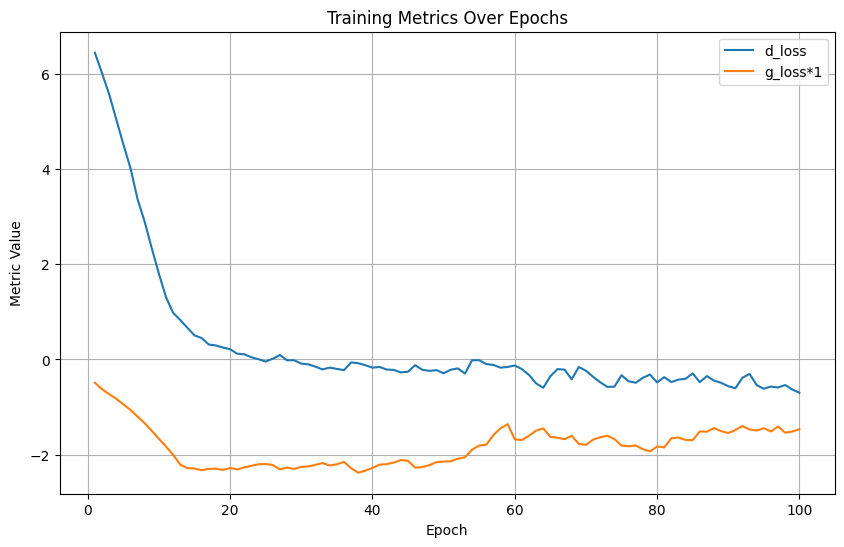

In [3]:
plot_training_metrics(f"{latest_model_path}/logs", generator_loss_scaling=1)

In [4]:
targets = ["OC_next", "CO_next"]
features = ["Close", "High", "Low", "Open", "Volume", "MACD", "Signal_Line", "EMA_20"]
tickers = ['GOOG','AAPL','MSFT','AMZN']

## Load data

In [5]:
# Load data
feature_data, target_data = process_model_data(targets, features, tickers)

/Users/a01milner/Documents/Schro-horse/functions/data_preperation.py:16: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(tickers, start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed
/Users/a01milner/Documents/Schro-horse/functions/data_preperation.py:16: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(tickers, start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed
/Users/a01milner/Documents/Schro-horse/functions/data_preperation.py:16: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(tickers, start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed
/Users/a01milner/Documents/Schro-horse/functions/data_preperation.py:16: FutureWarning: YF.download() has changed argument auto_adjust default to True
  d

(1003, 32) (1003, 8)


2025-10-01 22:46:50.352058: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2 Pro
2025-10-01 22:46:50.352090: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2025-10-01 22:46:50.352095: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2025-10-01 22:46:50.352111: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-10-01 22:46:50.352122: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


## Load the Qiskit circuit

[Parameter(W0), Parameter(W1), Parameter(W10), Parameter(W11), Parameter(W12), Parameter(W13), Parameter(W14), Parameter(W15), Parameter(W16), Parameter(W17), Parameter(W18), Parameter(W19), Parameter(W2), Parameter(W20), Parameter(W21), Parameter(W22), Parameter(W23), Parameter(W24), Parameter(W25), Parameter(W26), Parameter(W27), Parameter(W28), Parameter(W29), Parameter(W3), Parameter(W30), Parameter(W31), Parameter(W32), Parameter(W33), Parameter(W34), Parameter(W35), Parameter(W36), Parameter(W37), Parameter(W38), Parameter(W39), Parameter(W4), Parameter(W40), Parameter(W41), Parameter(W42), Parameter(W43), Parameter(W44), Parameter(W45), Parameter(W46), Parameter(W47), Parameter(W5), Parameter(W6), Parameter(W7), Parameter(W8), Parameter(W9), Parameter(x0), Parameter(x1), Parameter(x10), Parameter(x11), Parameter(x12), Parameter(x13), Parameter(x14), Parameter(x15), Parameter(x16), Parameter(x17), Parameter(x18), Parameter(x19), Parameter(x2), Parameter(x20), Parameter(x21), Para

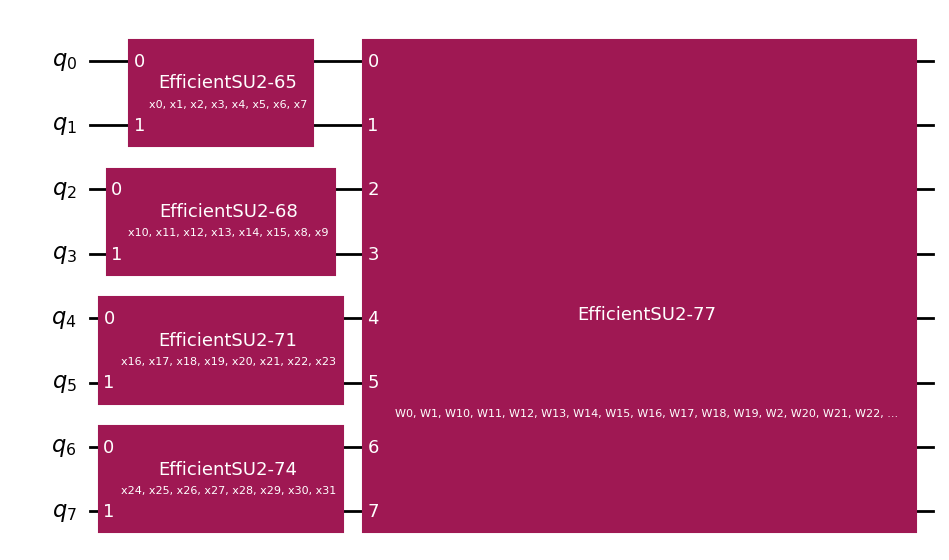

In [16]:
# Load circuit
qc= two_qubit_circuit_tickers(tickers)
print(list(qc.parameters))
qc.draw('mpl')

In [7]:
# Load weights
loaded_weights = np.load(f"{latest_model_path}/generator.npy")

In [8]:
# Generate Data
# data is randomly sampled so returns the generated data along with the associated real data (if samplig=True)

backend = GenericBackendV2(num_qubits=qc.num_qubits)

outputs, target_outputs = generate_data(
    generator_weights = loaded_weights,
    qc = qc,
    feature_data = feature_data,
    target_data = target_data,
    backend = backend,
    sampling = True,
    sample_size = 100,
)

## Finding the Root Mean Squared Errors
This is a better accuracy metric for us as the generator/discriminator loss doesn't tell us much

An RMSE of 0.10 means we are off by 10%

In [9]:
# Calculate RMSE for each ticker and output feature
rmse_dict = calculate_rmse(
    generated_data= outputs,
    target_data= target_outputs, 
    ticker_labels= tickers,
    target_labels = targets
)

for k, v in rmse_dict.items():
        print(f"{k}: {v:.4f}")

avg_rmse = mean_squared_error(target_outputs, outputs)
print(f"Average RMSE: {avg_rmse}")

GOOG_OC_next: 1.2351
GOOG_CO_next: 0.9288
AAPL_OC_next: 0.8494
AAPL_CO_next: 1.2961
MSFT_OC_next: 1.0694
MSFT_CO_next: 1.1724
AMZN_OC_next: 1.5156
AMZN_CO_next: 1.4459
Average RMSE: 1.4618723392486572


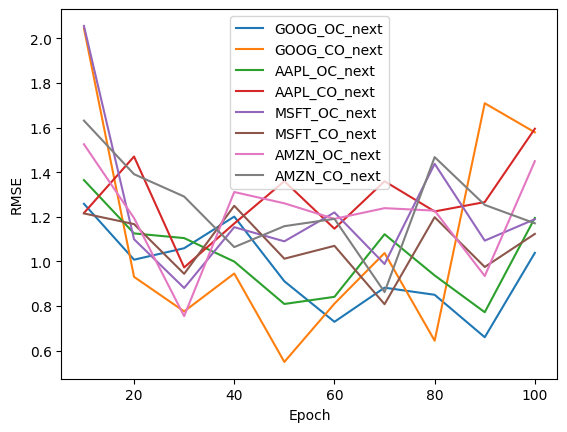

In [10]:
# Plot the RMSE per epoch
rmse_per_epoch=plot_rmse_per_epoch(model_path=latest_model_path,
                    qc=qc, 
                    feature_data=feature_data, 
                    target_data=target_data, 
                    target_labels=targets, 
                    ticker_labels=tickers, 
                    sample_size = 100,
                    every_n_epochs=10,
)

## Comparing to random weights

In [11]:
random_weights = np.random.randn(len(loaded_weights))

random_outputs, random_target_outputs = generate_data(
    generator_weights = loaded_weights,
    qc = qc,
    feature_data = feature_data,
    target_data = target_data,
    backend = backend,
    sampling = True,
    sample_size = 500,
)
random_rmse = mean_squared_error(random_target_outputs, random_outputs)
print(f"Average RMSE for random weights: {random_rmse}")
print(f"Average RMSE for trained weights: {avg_rmse}")

Average RMSE for random weights: 1.539625883102417
Average RMSE for trained weights: 1.4618723392486572


## Plotting the ticker comparison distributions

In [12]:
# Turning the results into a df
columns = [f"{ticker}_{target}" for ticker in tickers for target in targets]

df_gen = pd.DataFrame(outputs, columns=columns)
df_real = pd.DataFrame(target_outputs, columns=columns)


In [13]:
df_gen.head()

,GOOG_OC_next,GOOG_CO_next,AAPL_OC_next,AAPL_CO_next,MSFT_OC_next,MSFT_CO_next,AMZN_OC_next,AMZN_CO_next
0,-1.792169,-1.595483,-0.444164,-1.131223,-1.952046,0.997011,-0.688984,-2.046635
1,-0.848748,0.543793,-0.341403,0.367848,-1.119827,-0.481742,-1.877558,-0.823400
2,0.248665,-1.074331,-1.018083,-0.379667,-2.360528,-0.840291,0.053170,0.102943
3,-1.216414,-0.635856,-0.125756,0.965713,1.530277,0.184402,-1.078419,-1.111824
4,-2.608021,0.712988,-1.819269,1.637910,-2.196871,-1.425747,-0.621943,1.535043


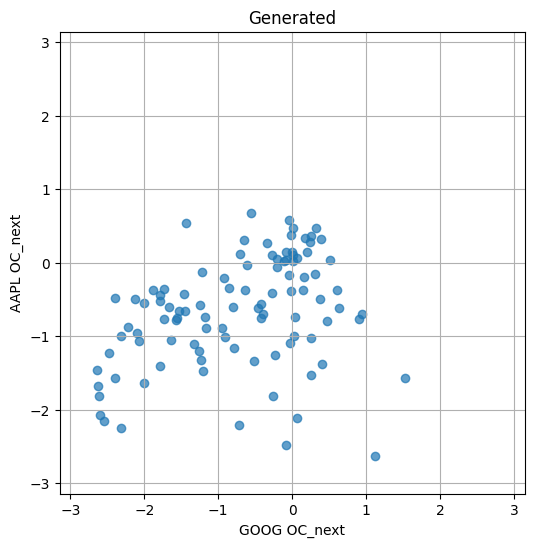

In [14]:
compare_tickers_scatter(df_gen, "GOOG", "AAPL", title= "Generated", feature="OC_next")

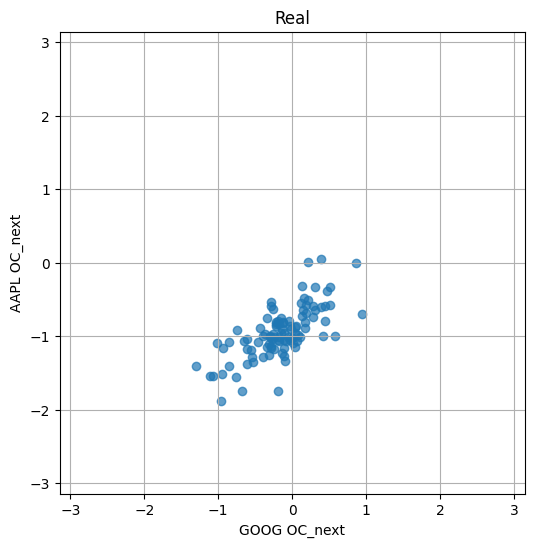

In [15]:
compare_tickers_scatter(df_real, "GOOG", "AAPL",title= "Real", feature="OC_next")